In [24]:
import pandas as pd
import numpy as np
from copy import deepcopy
import gc
from tqdm import tqdm_notebook
import sys
sys.path.append('/home/ndsviriden/MinMax94/src/utils')
from Preprocessing import Preprocessor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [25]:
%%time
# getting file tree in directory "data_csv", which contains raw unfiltered data
station_list = [113, 114, 612, 115, 116, 117, 118, 119, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 
               1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1823, 1824, 1825, 1826, 1827, 1828, 1829]
mypath = '/mnt/HARD/MinMax94/data/data_all/CSV/Raw_extended/'

# reading loaded csv files from data_csv directory, output is a list (length=number of stations) of raw df
raw_list = [pd.read_csv(mypath + str(station_id) + '_raw.csv', parse_dates = ['date_time']) 
              for station_id in station_list]
raw_lmeteo = pd.concat(raw_list)

CPU times: user 32.7 s, sys: 384 ms, total: 33.1 s
Wall time: 33.1 s


In [26]:
%%time
preprocessor = Preprocessor()
useful_features = ['t_air', 't_road', 't_underroad', 'pressure', 'dampness', 'cloudiness']
raw_lmeteo = preprocessor.SelectFeatures(raw_lmeteo, useful_features)
lmeteo_pivot = preprocessor.PivotTable(raw_lmeteo)
lmeteo_pivot = preprocessor.FixPressureScale(lmeteo_pivot)
lmeteo_patterns = preprocessor.CreatePatternList(lmeteo_pivot)
lmeteo_interpolated = preprocessor.InterpolatePatterns(lmeteo_patterns)

CPU times: user 26.4 s, sys: 888 ms, total: 27.3 s
Wall time: 27.3 s


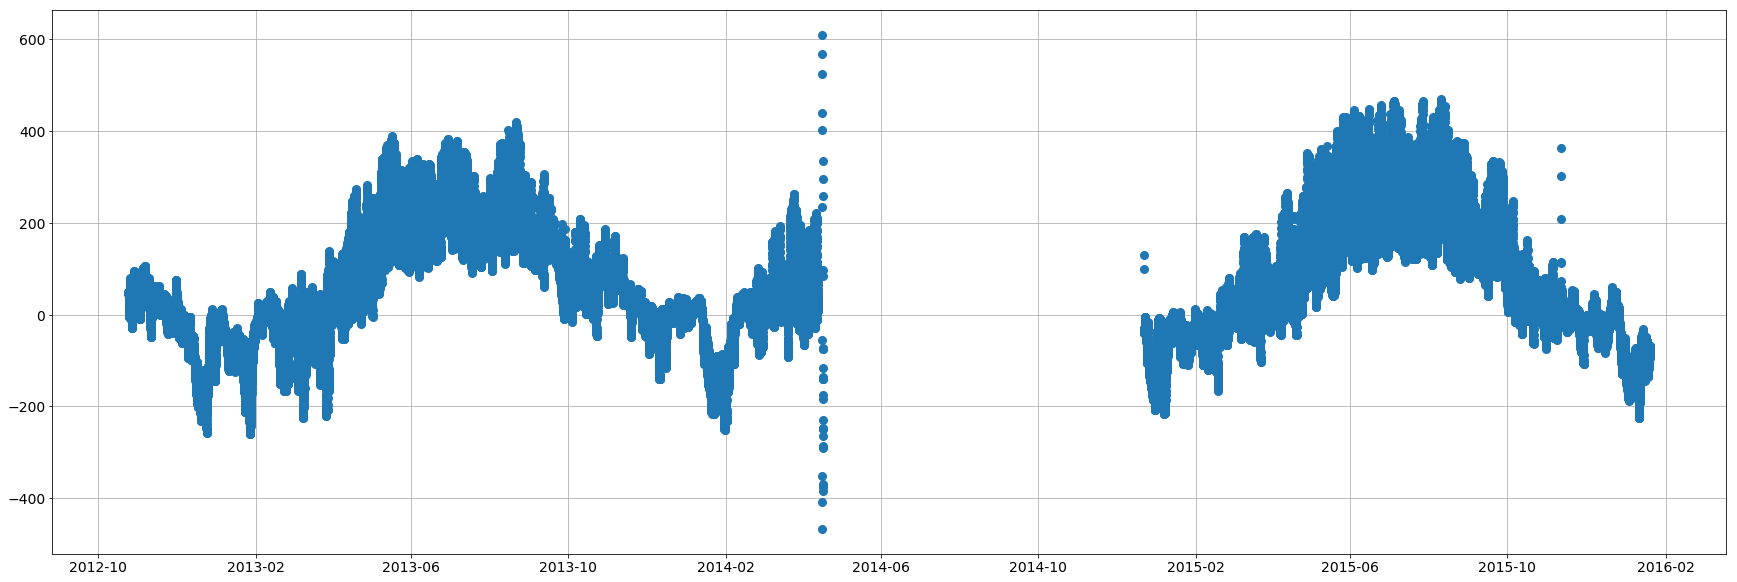

In [33]:
#mask_uno = (lmeteo_interpolated.index > pd.Timestamp(2016, 1, 1)) & (lmeteo_interpolated.index < pd.Timestamp(2016, 2, 1))
#mask_dos = lmeteo_interpolated[lmeteo_interpolated['station_id']==113]
test = deepcopy(lmeteo_interpolated)
test = test[test['station_id']==612]
mask1 = (test.index > pd.Timestamp(2016, 1, 10, 12)) & (test.index < pd.Timestamp(2016, 1, 10, 20))
mask2 = (test.index > pd.Timestamp(2016, 1, 20))
mask3 = (test.index > pd.Timestamp(2016, 1, 15, 12)) & (test.index < pd.Timestamp(2016, 1, 15, 16))

test['data_t_road'][mask1] = np.nan
test['data_t_road'][mask2] = np.nan

start = pd.Timestamp(2012, 1, 10, 9)
end = pd.Timestamp(2017, 1, 10, 19)

to_plot = test[(test.index <= end) & (test.index >= start)]

plt.figure(figsize=(30, 10))
plt.plot_date(to_plot.index, to_plot['data_t_road'], markersize=8)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()